In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random

%matplotlib inline

plt.style.use('ggplot')

# 1. Data Loading

In [2]:
# Load data
train = pd.read_csv('./data/train_transformed.csv')
X_test = pd.read_csv('./data/test_transformed.csv')

# Prepare features and target
X_full = train.drop('SalePrice', axis=1)
y_full = train.SalePrice

# Split the training data into training and dev sets.
X_train, X_dev, y_train, y_dev = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# Add missing 1-hot encoded columns to X_test to match X_train
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = False

# Drop column MSSubClass_150 from X_test and align its columns with X_train
X_test.drop('MSSubClass_150', axis=1, inplace=True)
X_test = X_test[X_train.columns]

# 2. PyTorch Setup

In [3]:
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Convert the pandas DataFrames to float32 numeric arrays and then to PyTorch tensors.
# Training tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32).to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.astype(np.float32).to_numpy(), dtype=torch.float32).unsqueeze(1)

# Development tensors
X_dev_tensor = torch.tensor(X_dev.astype(np.float32).to_numpy(), dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev.astype(np.float32).to_numpy(), dtype=torch.float32).unsqueeze(1)

# Test tensors
X_test_tensor  = torch.tensor(X_test.astype(np.float32).to_numpy(), dtype=torch.float32)

# Create DataLoaders for mini-batch training and evaluation.
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# 3. Feed-forward Neural Network Class

In [4]:
# Define a simple feed-forward neural network.
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer for regression
        )
    
    def forward(self, x):
        return self.net(x)

# 4. RMSE  Log Loss Function

This loss function computes the **Root Mean Squared Error (RMSE)** of the logarithms of the predictions and targets. The goal is to compare values on a logarithmic scale, which can be especially useful when dealing with targets that span several orders of magnitude. Before taking the logarithm, both the predictions and targets are clamped* to a small positive value (epsilon) to avoid issues with \(\log(0)\).

Mathematically, given predictions $\hat{y}_i$ and true values $y_i$, the loss is defined as:

$$
\text{RMSE}_{\log} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left( \log(\hat{y}_i) - \log(y_i) \right)^2 }
$$

where:
- $N$ is the number of samples,
- $\hat{y}_i$ is the predicted value for the $i$-th sample,
- $y_i$ is the true target value for the $i$-th sample,
- A clamping operation ensures that both $\hat{y}_i$ and $y_i$ are at least $\epsilon$ (e.g., $1 \times 10^{-7}$).

\* *Clamping restricts a value so it remains within a specified range. In our loss function, this ensures both predictions and target values have a minimum value $\epsilon$. This ensures we don't take a logarithm of a non-positive number (which is undefined). Essentially, clamping forces every value to be at least $\epsilon$, which helps prevent errors when computing the log.*

In [5]:
# Custom loss function: RMSE of log-transformed values.
def rmse_log_loss(pred, target, epsilon=1e-7):
    # Clamp to ensure positivity
    pred = torch.clamp(pred, min=epsilon)
    target = torch.clamp(target, min=epsilon)
    return torch.sqrt(torch.mean((torch.log(pred) - torch.log(target)) ** 2))

# 5. Model Instantiation

In [6]:
# Instantiate the model.
input_dim = X_train_tensor.shape[1]
model = FeedForwardNN(input_dim)

# 6. Model Training

In [7]:
# Define the optimizer.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Containers to record epoch numbers and losses.
epochs = []
train_losses = []
dev_losses = []

# Training loop.
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    # Iterate over batches from the training loader.
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()               # Clear gradients
        outputs = model(batch_X)              # Forward pass
        loss = rmse_log_loss(outputs, batch_y)  # Compute training loss
        loss.backward()                       # Backpropagation
        optimizer.step()                      # Update weights
        epoch_train_loss += loss.item() * batch_X.size(0)
    
    # Average training loss across batches.
    epoch_train_loss /= len(train_loader.dataset)
    
    # Evaluation on the dev set.
    model.eval()
    epoch_dev_loss = 0.0
    with torch.no_grad():
        for dev_X, dev_y in dev_loader:
            dev_outputs = model(dev_X)
            loss_dev = rmse_log_loss(dev_outputs, dev_y)
            epoch_dev_loss += loss_dev.item() * dev_X.size(0)
    epoch_dev_loss /= len(dev_loader.dataset)
    
    # Record losses and epoch number.
    epochs.append(epoch + 1)
    train_losses.append(epoch_train_loss)
    dev_losses.append(epoch_dev_loss)

    # print for every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Training RMSE Log Loss: {epoch_train_loss:.4f}, Dev RMSE Log Loss: {epoch_dev_loss:.4f}")

Epoch [100/500], Training RMSE Log Loss: 0.1868, Dev RMSE Log Loss: 0.1950
Epoch [200/500], Training RMSE Log Loss: 0.1661, Dev RMSE Log Loss: 0.1777
Epoch [300/500], Training RMSE Log Loss: 0.1322, Dev RMSE Log Loss: 0.1532
Epoch [400/500], Training RMSE Log Loss: 0.1168, Dev RMSE Log Loss: 0.1430
Epoch [500/500], Training RMSE Log Loss: 0.1163, Dev RMSE Log Loss: 0.1381


# 7. Loss Curves

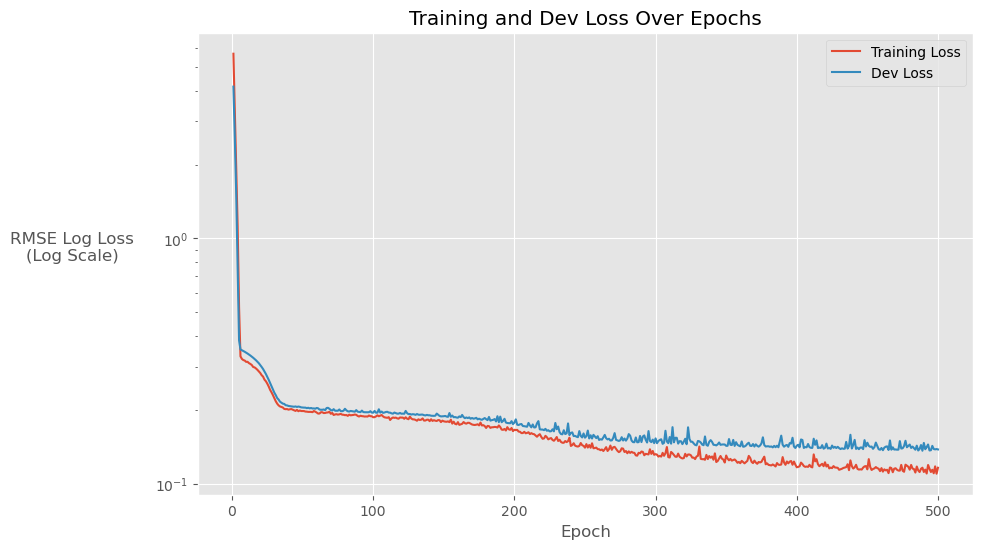

Final Training Loss: 0.1163
Final Dev Loss: 0.1381


In [8]:
# Plot both training and dev losses on the same chart.
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, dev_losses, label='Dev Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Log Loss\n(Log Scale)', rotation=0, labelpad=60)
plt.title('Training and Dev Loss Over Epochs')
plt.legend()
plt.yscale('log')
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Dev Loss: {dev_losses[-1]:.4f}")

# 8. Predict on Test Set with Fully Trained Model

In [9]:
# Set the model to evaluation mode for predictions.
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    #print("Predictions on X_test:")
    #print(predictions)

# Create a submission DataFrame and save predictions.
nn_submission = pd.DataFrame()
nn_submission['Id'] = X_test['Id']
nn_submission['SalePrice'] = predictions.squeeze()  # Remove extra dimension if any

# 9. Write to Submission File

In [10]:
file_name = 'submission-nn.csv'
nn_submission.to_csv(file_name, index=False)
print(f"Submission file created: {file_name}")

Submission file created: submission-nn.csv
